In [1]:
# %pip install -q pandas pyarrow s3fs joblib scikit-learn

# Credit Scorecard Project – Logist Regression

## 1. Modelling Prep

### 1.1 Test S3 Access

In [2]:
import boto3
import pandas as pd

In [3]:
s3 = boto3.client('s3')
BUCKET = "scorecard-project-data"

resp = s3.list_objects_v2(Bucket=BUCKET, Prefix="data-processed/")
[k["Key"] for k in resp.get("Contents", [])][:10]

['data-processed/',
 'data-processed/test_woe.csv',
 'data-processed/test_woe.parquet',
 'data-processed/train_woe.csv',
 'data-processed/train_woe.parquet']

In [4]:
file_key = "data-processed/train_woe.csv"  # adjust path & filename
s3_path = f"s3://{BUCKET}/{file_key}"

# load only first 100k rows to keep memory low on t3.medium
train_small = pd.read_csv(s3_path, nrows=100_000, storage_options={"anon": False})

print(train_small.shape)
train_small.head()

(100000, 40)


,loan_amnt_woe,int_rate_woe,annual_inc_woe,dti_woe,fico_range_low_woe,inq_last_6mths_woe,mths_since_last_major_derog_woe,mths_since_rcnt_il_woe,total_bal_il_woe,open_rv_24m_woe,...,purpose_woe,f_term_60_woe,f_hi_risk_zip_woe,f_miss_block1_woe,F_CAPPED_NUMACCTS_woe,F_OVERLIMIT_woe,f_collections_12_mths_ex_med_gt0_woe,F_CAPPED_AMOUNT_woe,F_CAPPED_INC_woe,GB_FLAG
0,0.247709,-0.101660,-0.085682,0.407503,-0.209055,-0.087473,-0.099002,-0.095243,-0.086428,-0.276538,...,0.074256,-0.289545,-0.018224,0.190383,-0.004371,-0.012829,-0.004973,0.003301,0.002591,0.0
1,-0.145315,0.247789,-0.036640,0.104344,0.288846,-0.381161,0.042158,-0.095243,-0.209313,-0.276538,...,0.343263,-0.289545,-0.018224,0.190383,-0.004371,-0.012829,-0.004973,0.003301,0.002591,0.0
2,-0.046834,-1.158514,0.253059,-0.172244,0.024729,-0.381161,0.042158,-0.095243,-0.232708,-0.515710,...,-0.119231,0.700895,-0.018224,0.190383,-0.004371,-0.012829,-0.004973,0.003301,0.002591,0.0
3,-0.046834,-0.101660,-0.206657,0.286299,-0.040825,0.135680,0.042158,0.026584,-0.086428,0.086018,...,0.074256,-0.289545,-0.018224,0.190383,-0.004371,-0.012829,-0.004973,0.003301,0.002591,0.0
4,-0.145315,0.740510,0.399693,0.128645,-0.175425,0.135680,0.042158,-0.095243,-0.232708,-0.276538,...,0.074256,-0.289545,-0.018224,0.190383,-0.004371,0.364972,-0.004973,0.003301,0.002591,0.0


### 1.2 Convert CSV to Parquet for Optimising Memory

In [5]:
BUCKET = "scorecard-project-data"
files = [
    "data-processed/train_woe.csv",
    "data-processed/test_woe.csv"
]


for key in files:
    src = f"s3://{BUCKET}/{key}"
    dst = f"s3://{BUCKET}/{key.replace('.csv', '.parquet')}"
    print("Converting ->", src, "to", dst)
    df = pd.read_csv(src)                      # load whole file
    df.to_parquet(dst, index=False)
print("Done.")


Converting -> s3://scorecard-project-data/data-processed/train_woe.csv to s3://scorecard-project-data/data-processed/train_woe.parquet
Converting -> s3://scorecard-project-data/data-processed/test_woe.csv to s3://scorecard-project-data/data-processed/test_woe.parquet
Done.


In [6]:
file_names = [
    "data-processed/train_woe",
    "data-processed/test_woe"
]

for f in file_names:
    csv_path = f"s3://{BUCKET}/{f}.csv"
    pq_path = f"s3://{BUCKET}/{f}.parquet"
    
    # Row counts
    csv_rows = pd.read_csv(csv_path, nrows=5).shape[1]  
    pq_rows = pd.read_parquet(pq_path).shape[1]
    
    print(f"{f}:")
    print(f"  CSV sample columns: {csv_rows}")
    print(f"  Parquet sample columns: {pq_rows}")
    print("  (Full row count check skipped here to save time/memory)\n")

data-processed/train_woe:
  CSV sample columns: 40
  Parquet sample columns: 40
  (Full row count check skipped here to save time/memory)

data-processed/test_woe:
  CSV sample columns: 40
  Parquet sample columns: 40
  (Full row count check skipped here to save time/memory)



### 1.3 Import Packages and Load Data

from scorecard-project-data/docs/requirements.txt

In [7]:
# !pip install -r requirements.txt

In [112]:
import boto3

import numpy as np
import pandas as pd 

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, precision_recall_fscore_support

import matplotlib.pyplot as plt

import json
import joblib

In [9]:
s3 = boto3.client('s3')

BUCKET = 'scorecard-project-data'
s3_key = 'docs/requirements.txt'
local_file_path = 'requirements.txt' # download to JupyterLab directory

s3.download_file(BUCKET, s3_key, local_file_path)
print("File downloaded :)")

File downloaded :)


In [10]:
# Load data
df_train = pd.read_parquet("s3://scorecard-project-data/data-processed/train_woe.parquet")
df_test = pd.read_parquet("s3://scorecard-project-data/data-processed/test_woe.parquet")

print(df_train.shape)
print(df_test.shape)

# Load meta data
summary = pd.read_csv("s3://scorecard-project-data/meta/binning_summary.csv")

(1074238, 40)
(205520, 40)


## 2. Baseline Model

In [11]:
# Define predictors
keep_vars = list(summary[summary['decision']=='keep']['variable'])
keep_vars.remove('int_rate') # remove interest rate for the base model

suffix = "_woe"
base_features = [var + suffix for var in keep_vars]

len(base_features)

23

In [12]:
# Split X and y

X_train = df_train[base_features]
y_train = df_train['GB_FLAG']

X_test = df_test[base_features]
y_test = df_test['GB_FLAG']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1074238, 23) (1074238,) (205520, 23) (205520,)


In [13]:
# Standardise features 
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### 2.1 L1 Regularisation

In [25]:
# Set up logistic regression with L1 regularisation
l1_model = LogisticRegressionCV(
    Cs=10,                     # Number of values for C to try
    cv=5,                      # 5-fold cross-validation
    penalty="l1",              # L1 regularisation
    solver="liblinear",        # Solver that supports L1
    scoring="roc_auc",         # Optimise AUC
    max_iter=1000,
    n_jobs=-1,
    random_state=42
)

# Fit model
l1_model.fit(X_train_scaled, y_train)

LogisticRegressionCV(cv=5, max_iter=1000, n_jobs=-1, penalty='l1',
                     random_state=42, scoring='roc_auc', solver='liblinear')

In [26]:
# Predict on the test set - default threshold hold 0.5
y_pred_l1 = l1_model.predict(X_test_scaled)
y_pred_l1_proba = l1_model.predict_proba(X_test_scaled)[:, 1] # probability of class 1

#### 2.1.1 Model Performance Diagnostics 

In [27]:
# Evaluate Model Performance 

# AUC
auc_l1 = roc_auc_score(y_test, y_pred_l1_proba)

# Accuracy
acc_l1 = accuracy_score(y_test, y_pred_l1)

# Precision, recall and f1_score of class 1
p1, r1, f1_1, _ = precision_recall_fscore_support(
     y_test, y_pred_l1, labels=[1], average=None, zero_division=0
)

# KS statistics
fpr, tpr, thresholds = roc_curve(y_test, y_pred_l1_proba)
ks = max(tpr - fpr)

# Put together a performance df
l1_perf = {
    "model": ["L1"],
    "predictors": ["23 base features"],
    "threshold": [0.5],
    "C": ["default"],
    "auc": [round(auc_l1, 4)],
    "accuracy": [round(acc_l1, 4)],
    "precision": [round(p1[0], 4)],
    "recall": [round(r1[0],4)],
    "f1-score": [round(f1_1[0],4)],
    "KS": [round(ks,4)]
}
perf_df = pd.DataFrame(l1_perf)

# absConfusion matrix & Classification report 
cm_l1 = confusion_matrix(y_test, y_pred_l1)
report_l1 = classification_report(y_test, y_pred_l1)

print("Confusion Matrix:")
print(cm_l1)
# print("\nClassification Report:")
# print(report_l1) 


perf_df


Confusion Matrix:
[[159106   3318]
 [ 39655   3441]]


,model,predictors,threshold,C,auc,accuracy,precision,recall,f1-score,KS
0,L1,23 base features,0.5,default,0.6889,0.7909,0.5091,0.0798,0.138,0.2744


**Overall Accuracy: 79%**
* With overall bad rate of ~20%; 79% accuracy likely just means the model is defaulting to predicting most loans as ‘good’ (0s).

**Bad Class (1 — Defaults):**
* Recall = 0.08 → The model is only catching 8% of actual bad loans.
* Precision = 0.51 → Of the loans it predicted as bad, only 51% were truly bad.

**Next Step**: Check ROC curve

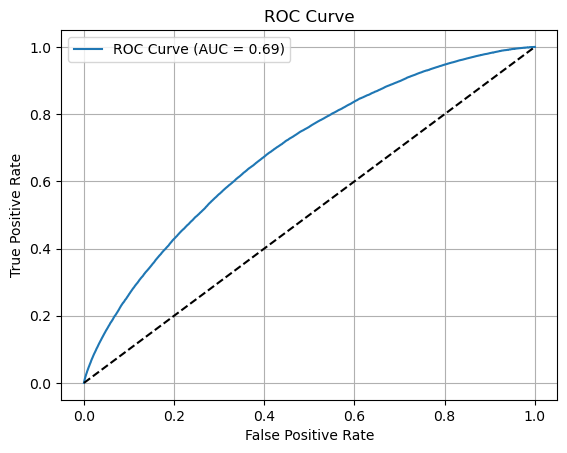

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_l1_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_l1:.2f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

**AUC = 0.69:**
* When comparing one random good borrower and one bad borrower, there's a 69% chance the model will score the good one higher.
* It's better than random (0.5), but there's room to grow.

**Curve shape:**
* It’s bowed above the diagonal, which means the model does have signal butno strong enough to confidently identify risky borrowers without a lot of false positives.
* No sharp bend near top-left (signal of high recall and low false positive rate), which confirms that:
    * the model may be underpowered, or
    * it may be biased toward predicting the majority class (0s), or
    * the threshold (0.5) is too conservative.

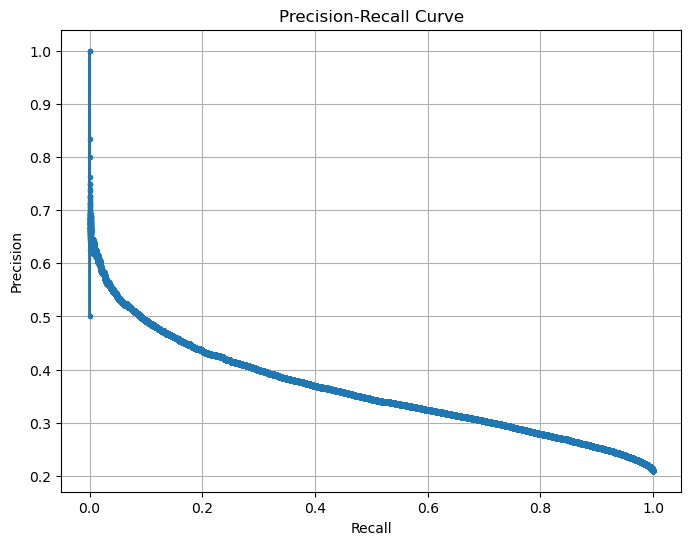

In [18]:
# Precision-Recall curve

y_pred_l1_proba = l1_model.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_l1_proba) 

plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

**The curve drops steeply from precision ≈ 1 when recall is very low**
* At very low recall (catching very few bad loans), the precision is high — meaning when the model says “this is bad,” it’s often right.
* But it misses most bad loans (very low recall), so not very useful operationally

**The rest of the curve shows a slow, steady decline**
* the precision drops steadily as recall increases, settling around 0.3–0.4
* Once start being more aggressive in labeling bads, there will be more and more false positives.

**Conclusion:**
* There is signal in the model, but it’s not strong enough to confidently identify most bads.
* The default threshold of 0.5 is likely too high.

**Next Step:** Find optional decision threshold that balances preciesion and recall.

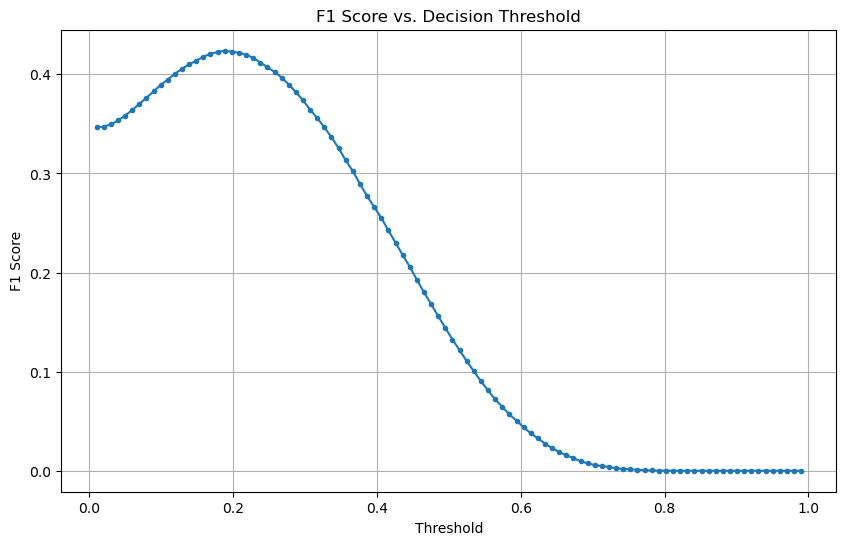

In [19]:
# F1 score - threshold curve

y_pred_l1_proba = l1_model.predict_proba(X_test_scaled)[:, 1]

thresholds = np.linspace(0.01, 0.99, 100)

f1_scores = []
for thresh in thresholds:
    y_pred_l1 = (y_pred_l1_proba > thresh).astype(int)
    f1 = f1_score(y_test, y_pred_l1)
    f1_scores.append(f1)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, marker='.')
plt.title('F1 Score vs. Decision Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

**Optimal Threshold**

It's clear from the F1-threshold graph that the optimal threshold sits around 0.2.

In [29]:
# Model performance at decision-threshold 0.2

y_pred_l1_proba = l1_model.predict_proba(X_test_scaled)[:, 1]
y_pred_l1_opt = (y_pred_l1_proba >= 0.2).astype(int)

# AUC
auc_l1_opt = roc_auc_score(y_test, y_pred_l1_proba)

# Accuracy
acc_l1_opt = accuracy_score(y_test, y_pred_l1_opt)


# Precision, recall and f1_score of class 1
p1_opt, r1_opt, f1_1_opt, _ = precision_recall_fscore_support(
     y_test, y_pred_l1_opt, labels=[1], average=None, zero_division=0
)

# KS statistics
fpr_opt, tpr_opt, thresholds_opt = roc_curve(y_test, y_pred_l1_proba)
ks_opt = max(tpr_opt - fpr_opt)

# Append to the performance dataframe
l1_opt_perf = pd.Series({
    "model": "L1",
    "predictors": "23 base features",
    "threshold": 0.2,
    "C": "default",
    "auc": round(auc_l1_opt, 4),
    "accuracy": round(acc_l1_opt, 4),
    "precision": round(p1_opt[0], 4),
    "recall": round(r1_opt[0], 4),
    "f1-score": round(f1_1_opt[0], 4),
    "KS": round(ks_opt,4),
})
perf_df = pd.concat([perf_df, l1_opt_perf.to_frame().T], ignore_index=True)


# Confusion matrix & Classification report 
cm_l1_opt = confusion_matrix(y_test, y_pred_l1_opt)
report_l1_opt = classification_report(y_test, y_pred_l1_opt)


print("Confusion Matrix:")
print(cm_l1_opt)
# print("\nClassification Report:")
# print(report_l1_opt)

perf_df

Confusion Matrix:
[[102475  59949]
 [ 15453  27643]]


,model,predictors,threshold,C,auc,accuracy,precision,recall,f1-score,KS
0,L1,23 base features,0.5,default,0.6889,0.7909,0.5091,0.0798,0.138,0.2744
1,L1,23 base features,0.2,default,0.6889,0.6331,0.3156,0.6414,0.423,0.2744


**With decisioin threshold set at 0.2**
* Recall of the bad class improved significant (from 0.08 to 0.64)
* Precision dropped as recall-precision chart showed, but f1-score increased to 0.423 as an overall gain

**Next Step:** 
* For now, use decision threshold of 0.2 for all model comparison before fine-tuning it for the final model
* Check coefficients of the baseline L1 model

In [21]:
# Get coefficients and column names
coefs = l1_model.coef_[0]
feature_names = X_train.columns

# Create a DataFrame of coefficients
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefs': coefs
})

# Filter out zero coefficients
nonzero_coefs = coef_df[coef_df['coefs'] != 0]

# Sort by absolute value
nonzero_coefs_sorted = nonzero_coefs.reindex(
    nonzero_coefs['coefs'].abs().sort_values(ascending=False).index
)

print(f"Number of non-zero features: {len(nonzero_coefs_sorted)}")
nonzero_coefs_sorted

Number of non-zero features: 23


,feature,coefs
19,f_term_60_woe,0.402637
3,fico_range_low_woe,-0.214767
1,annual_inc_woe,-0.179307
0,loan_amnt_woe,-0.170950
7,bc_open_to_buy_woe,-0.162437
6,acc_open_past_24mths_woe,-0.149691
5,mths_since_rcnt_il_woe,-0.132855
2,dti_woe,-0.129559
15,home_ownership_grouped_woe,0.120254
17,addr_state_grouped_woe,0.112492


**No coefficients shrunk to zero**
* None of 23 predictors were completely discarded by the L1 penalty.

**Top contributing feature**
* `f_term_60`: +0.40 — Having a 60-month term (vs. 36-month) strongly increases delinquency risk. <font color='red'>Loan term being the top feature is unusual, it could indicate that loan term is an output feature of LC's internal risk assessment and contains leakage.</font>
* `fico_range_low`: -0.21 — As expected, lower FICO scores decrease the odds of good repayment.
* `annual_inc`: -0.17 — higher income decreases the likelihood of default.
* `loan_amnt`: -0.17 - as loan amount increases, delinquency goes down, which is counterintuitive unless the lender is granting higher loans only to lower-risk borrowers.<font color='red'>This indicates that loan_amnt is one of output variables of the risk-based pricing setup</font>

**Next Step:**
1. Re-fit the L1 model without `f_term_60` and `loan_amnt` and see if there's significant decline in model performance;
2. Fit a benchmark model with `int_rate`, `f_term_60` and `loan_amnt`


In [22]:
# Remove f_term_60 and loan_amnt from the feature set 
drop_list = ['f_term_60_woe', 'loan_amnt_woe']
base_features_v2  = [f for f in base_features if f not in drop_list]

# Split X and y again
X_train2 = df_train[base_features_v2]
y_train = df_train['GB_FLAG']

X_test2 = df_test[base_features_v2]
y_test = df_test['GB_FLAG']

# Standardise features again
scaler = StandardScaler()
X_train2_scaled = scaler.fit_transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)

print(X_train2_scaled.shape, y_train.shape, X_test2_scaled.shape, y_test.shape)


(1074238, 21) (1074238,) (205520, 21) (205520,)


In [30]:
# Re-fit L1 model 

l1_model_v2 = LogisticRegressionCV(
    Cs=10,                     # Number of values for C to try
    cv=5,                      # 5-fold cross-validation
    penalty="l1",              # L1 regularisation
    solver="liblinear",        # Solver that supports L1
    scoring="roc_auc",         # Optimise AUC
    max_iter=1000,
    n_jobs=-1,
    random_state=42
)

# Fit model
l1_model_v2.fit(X_train2_scaled, y_train)

LogisticRegressionCV(cv=5, max_iter=1000, n_jobs=-1, penalty='l1',
                     random_state=42, scoring='roc_auc', solver='liblinear')

In [31]:
# Model performance at optimal decision-threshold 0.2
THRESH = 0.20

y_pred_proba_l1v2 = l1_model_v2.predict_proba(X_test2_scaled)[:, 1]
y_pred_l1v2 = (y_pred_proba_l1v2 >= THRESH).astype(int)

# AUC
auc_l1v2 = roc_auc_score(y_test, y_pred_proba_l1v2)

# Accuracy
acc_l1v2 = accuracy_score(y_test, y_pred_l1v2)

# Precision, recall and f1_score of class 1
p1_v2, r1_v2, f1_1_v2, _ = precision_recall_fscore_support(
     y_test, y_pred_l1v2, labels=[1], average=None, zero_division=0
)

# KS statistics
fpr_v2, tpr_v2, thresholds_v2 = roc_curve(y_test, y_pred_proba_l1v2)
ks_v2 = max(tpr_v2 - fpr_v2)


# Put together a performance df
l1v2_perf = pd.Series({
    "model": "L1",
    "predictors": "21 base features v2 (excl. f_term_60 and loan_amnt)",
    "threshold": 0.2,
    "C": "default",
    "auc": round(auc_l1v2, 4),
    "accuracy": round(acc_l1v2, 4),
    "precision": round(p1_v2[0], 4),
    "recall": round(r1_v2[0],4),
    "f1-score": round(f1_1_v2[0],4),
    "KS": round(ks_v2, 4)
})
perf_df = pd.concat([perf_df, l1v2_perf.to_frame().T], ignore_index=True)

# Confusion matrix & Classification report 
cm_l1v2 = confusion_matrix(y_test, y_pred_l1v2)
report_l1v2 = classification_report(y_test, y_pred_l1v2)

print("Confusion Matrix:")
print(cm_l1v2)
# print("\nClassification Report:")
# print(report_l1v2)

perf_df

Confusion Matrix:
[[95391 67033]
 [15545 27551]]


,model,predictors,threshold,C,auc,accuracy,precision,recall,f1-score,KS
0,L1,23 base features,0.5,default,0.6889,0.7909,0.5091,0.0798,0.138,0.2744
1,L1,23 base features,0.2,default,0.6889,0.6331,0.3156,0.6414,0.423,0.2744
2,L1,21 base features v2 (excl. f_term_60 and loan_...,0.2,default,0.6582,0.5982,0.2913,0.6393,0.4002,0.2273


By removing `f_term_60` and `loan_term`
* Accuracy: dropped from 0.63 to 0.60 (-3pt)
* Precision: droppped from 0.32 to 0.29 (-3pt)
* Recall: drop negilible
* f1-score: dropped from 0.42 to 0.40 (-2pt)

The decline in performance is material, and we'll compare the performance with the benchmark model constructed from these two varialbes and `int_rate`.

**Next Step:** Check coefficients of the re-fitted L1 model without `f_term_60` and `loan_term`.

In [32]:
# Get coefficients and column names
coefs_v2 = l1_model_v2.coef_[0]
feature_names_v2 = X_train2.columns

# Create a DataFrame of coefficients
coef_df_v2 = pd.DataFrame({
    'feature': feature_names_v2,
    'coefs': coefs_v2
})

# Filter out zero coefficients
nonzero_coefs_v2 = coef_df_v2[coef_df_v2['coefs'] != 0]

# Sort by absolute value
nonzero_coefs_sorted_v2 = nonzero_coefs_v2.reindex(
    nonzero_coefs_v2['coefs'].abs().sort_values(ascending=False).index
)

print(f"Number of non-zero features: {len(nonzero_coefs_sorted_v2)}")
nonzero_coefs_sorted_v2

Number of non-zero features: 21


,feature,coefs
2,fico_range_low_woe,-0.198699
1,dti_woe,-0.180313
15,verification_status_woe,0.160998
5,acc_open_past_24mths_woe,-0.145414
6,bc_open_to_buy_woe,-0.135105
16,addr_state_grouped_woe,0.109256
4,mths_since_rcnt_il_woe,-0.097840
17,purpose_woe,0.097588
14,home_ownership_grouped_woe,0.086687
12,num_rev_tl_bal_gt_0_woe,-0.081419


**Observations:**
* `dti_woe` (-0.18): higher DTI should increase credit risk - a positive coefficient is expected. A strong negative one is counterintuitive — possibly indicating suppression or multicollinearity effects.
* `annual_inc_woe` (-0.065): a negative coefficient is expected, but the very small magnitude could mean the model is not leveraging it effectively, possibly due to overlap with other predictors (like fico_range, purpose, emp_length etc.)
* `acc_open_past_24mths_woe`(-0.145): More open accounts might indicate healthier credit behaviour, or riskier behaviour depending on context.

**Next Step:** Inspect the binning of the suspicious variables

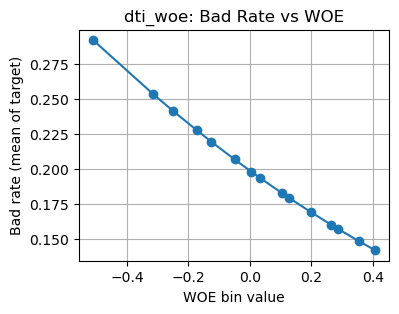

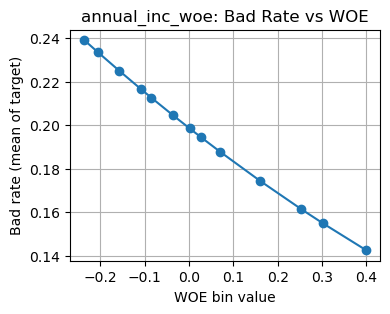

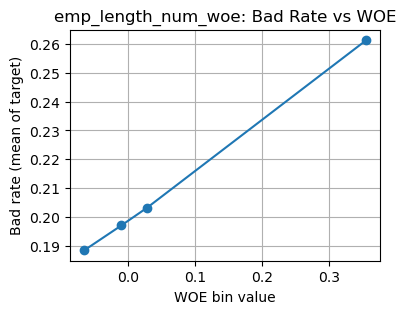

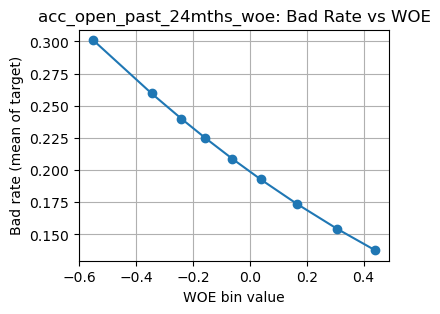

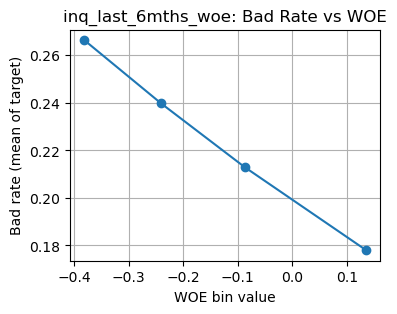

In [33]:
# List of suspicious variables
suspect_vars = [
    "dti_woe", 
    "annual_inc_woe",
    "emp_length_num_woe", 
    "acc_open_past_24mths_woe",
    "inq_last_6mths_woe"
]

for var in suspect_vars:
    df_plot = X_train.copy()
    df_plot['target'] = y_train.values 

    # Group by WOE value 
    grouped = df_plot.groupby(var)['target'].agg(['mean', 'count']).reset_index()

    plt.figure(figsize=(4,3))
    plt.plot(grouped[var], grouped['mean'], marker='o')
    plt.title(f"{var}: Bad Rate vs WOE")
    plt.xlabel("WOE bin value")
    plt.ylabel("Bad rate (mean of target)")
    plt.grid(True)
    plt.show()


The graphs shows: 

* Clear monotonic descent (i.e., bad rate goes down as WOE increases) for dti_woe, acc_open_past_24mnths_woe, inq_last_6mths_woe; 
* Clear monotonic ascent (i.e., bad rate goes up as WOE increases) for emp_length_num_woe, mnths_since_recent_inq_woe, mo_sin_old_rev_tl_op_woe.

The binning itself is behaving correctly: for each variable, the WOE transformation matches the expected monotonic relationship with bad rate.
* `dti` (−0.13 coef) vs. `annual_inc` (+0.19 coef), **corr = −0.24**
→ DTI is income-normalised debt, so no surprise there’s overlap. The model may be “trusting” annual income more, leaving DTI to take a weaker (and flipped) role.

* `inq_last_6mths` (−0.06 coef) vs. `mths_since_recent_inq` (+0.07 coef), **corr = −0.42**
→ basically two sides of the same concept. If one says “lots of recent inquiries” the other says “not long since last inquiry.” No surprise they’re pulling in opposite directions.

* `acc_open_past_24mths` (−0.15 coef) vs. `num_rev_tl_bal_gt_0_woe` (−0.07 coef), **corr = 0.33**
→  Both measure breadth of activity (new accounts vs. accounts with balances). Redundancy can blur their individual signs.

**Next step:** Try removing some of the overlapped features, see if contradicting signs resolve & model performance decreases significantly.

#### 2.1.2 Feature Pruning

In [34]:
# Define a function for quick fitting and evaulation of L1 model using different feature set

THRESH = 0.20
C_FIXED = 1.0

# --- one-time: make an inner validation split from the dev set (2012-2016) ---
X_dev_train, X_dev_valid, y_dev_train, y_dev_valid = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

def fit_eval(features, return_model=False):
    Xtr = X_dev_train[features]
    Xva = X_dev_valid[features]

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            penalty="l1",
            solver="liblinear",
            C=C_FIXED,
            max_iter=1000,
            random_state=42
        ))
    ])
    pipe.fit(Xtr, y_dev_train)

    proba = pipe.predict_proba(Xva)[:, 1]
    y_pred = (proba >= THRESH).astype(int)

    auc = roc_auc_score(y_dev_valid, proba)
    p1, r1, f1, _ = precision_recall_fscore_support(
        y_dev_valid, y_pred, labels=[1], average=None, zero_division=0
    ) 

    fpr, tpr, threshods = roc_curve(y_dev_valid, proba)
    ks = max(tpr - fpr)

    metrics = {
        "auc": round(auc, 4),
        "prec1": round(p1[0], 4),
        "recall1": round(r1[0], 4),
        "f1_1": round(f1[0], 4),
        "KS": round(ks, 4)
    }
    return (metrics, pipe) if return_model else metrics

In [35]:
# Define a function to test redundant features 
def fit_eval_drop(drop_list=[]):
    final_features = [f for f in base_features if f not in drop_list]
    return fit_eval(final_features)

In [36]:
# 21 features 
baseline_metrics = fit_eval(base_features_v2)
baseline_metrics

{'auc': 0.6675,
 'prec1': 0.2858,
 'recall1': 0.6312,
 'f1_1': 0.3934,
 'KS': 0.2403}

In [37]:
# Drop dti
reduced_metrics = fit_eval_drop(["dti_woe"])
reduced_metrics

{'auc': 0.7106,
 'prec1': 0.3206,
 'recall1': 0.6458,
 'f1_1': 0.4285,
 'KS': 0.3066}

In [38]:
# Drop acc_open_past_24mnths
reduced_metrics = fit_eval_drop(["acc_open_past_24mths_woe"])
reduced_metrics

{'auc': 0.7107,
 'prec1': 0.3197,
 'recall1': 0.6452,
 'f1_1': 0.4275,
 'KS': 0.3052}

In [39]:
# Drop mths_since_recent_inq_woe
reduced_metrics = fit_eval_drop(["mths_since_recent_inq_woe"])
reduced_metrics

{'auc': 0.7125,
 'prec1': 0.3213,
 'recall1': 0.6449,
 'f1_1': 0.4289,
 'KS': 0.3079}

In [40]:
# Drop dti and num_rev_tl_bal_gt_0_woe
reduced_metrics = fit_eval_drop(["dti_woe", "acc_open_past_24mths_woe"])
reduced_metrics

{'auc': 0.7078,
 'prec1': 0.3179,
 'recall1': 0.6433,
 'f1_1': 0.4256,
 'KS': 0.3016}

In [41]:
# Drop dti, acc_open_past_24mnths, mths_since_recent_inq_woe
reduced_metrics = fit_eval_drop(["dti_woe", "mths_since_recent_inq_woe"])
reduced_metrics

{'auc': 0.7103,
 'prec1': 0.3203,
 'recall1': 0.6438,
 'f1_1': 0.4278,
 'KS': 0.3059}

In [42]:
# Drop dti, acc_open_past_24mnths, mths_since_recent_inq_woe
reduced_metrics = fit_eval_drop(["dti_woe", "acc_open_past_24mths_woe", "mths_since_recent_inq_woe"])
reduced_metrics

{'auc': 0.7071,
 'prec1': 0.3184,
 'recall1': 0.6431,
 'f1_1': 0.4259,
 'KS': 0.3019}

Using the scrambled training set, there's an improvement in performance when either of these features are removed:
* `dti`
* `acc_open_past_24mths_woe`
* `mths_since_recent_inq_woe`

**Next step:** fit the L1 model with the full training set without these three variables and examine the coefficients

In [43]:
# Drop dti, acc_open_past_24mnths, mths_since_recent_inq_woe
drop_list = ["dti_woe", "acc_open_past_24mths_woe"]
reduced_features  = [f for f in base_features_v2 if f not in drop_list]

# Split X and y again
X_train3 = df_train[reduced_features]
X_test3 = df_test[reduced_features]

# Standardise features again
scaler = StandardScaler()
X_train3_scaled = scaler.fit_transform(X_train3)
X_test3_scaled = scaler.transform(X_test3)

print(X_train3_scaled.shape, y_train.shape, X_test3_scaled.shape, y_test.shape)


(1074238, 19) (1074238,) (205520, 19) (205520,)


In [44]:
# Re-fit L1 model 

l1_model_v3 = LogisticRegressionCV(
    Cs=10,                     # Number of values for C to try
    cv=5,                      # 5-fold cross-validation
    penalty="l1",              # L1 regularisation
    solver="liblinear",        # Solver that supports L1
    scoring="roc_auc",         # Optimise AUC
    max_iter=1000,
    n_jobs=-1,
    random_state=42
)

# Fit model
l1_model_v3.fit(X_train3_scaled, y_train)

LogisticRegressionCV(cv=5, max_iter=1000, n_jobs=-1, penalty='l1',
                     random_state=42, scoring='roc_auc', solver='liblinear')

In [46]:
# Model performance at optimal decision-threshold 0.2
THRESH = 0.20

y_pred_proba_l1v3 = l1_model_v3.predict_proba(X_test3_scaled)[:, 1]
y_pred_l1v3 = (y_pred_proba_l1v3 >= THRESH).astype(int)

# AUC
auc_l1v3 = roc_auc_score(y_test, y_pred_proba_l1v3)

# Accuracy
acc_l1v3 = accuracy_score(y_test, y_pred_l1v3)

# Precision, recall and f1_score of class 1
p1_v3, r1_v3, f1_1_v3, _ = precision_recall_fscore_support(
     y_test, y_pred_l1v3, labels=[1], average=None, zero_division=0
)

# KS statistics
fpr_v3, tpr_v3, thresholds_v3 = roc_curve(y_test, y_pred_proba_l1v3)
ks_v3 = max(tpr_v3 - fpr_v3)

# Put together a performance df
l1v3_perf = pd.Series({
    "model": "L1",
    "predictors": "19 base features v2 minus dti, acc_open_past_24mths",
    "threshold": 0.2,
    "C": "default",
    "auc": round(auc_l1v3, 4),
    "accuracy": round(acc_l1v3, 4),
    "precision": round(p1_v3[0], 4),
    "recall": round(r1_v3[0],4),
    "f1-score": round(f1_1_v3[0],4),
    "KS": round(ks_v3, 4)
})
perf_df = pd.concat([perf_df, l1v3_perf.to_frame().T], ignore_index=True)

# Confusion matrix & Classification report 
cm_l1v3 = confusion_matrix(y_test, y_pred_l1v3)
report_l1v3 = classification_report(y_test, y_pred_l1v3)

print("Confusion Matrix:")
print(cm_l1v3)
# print("\nClassification Report:")
# print(report_l1v2)

perf_df

Confusion Matrix:
[[90538 71886]
 [14642 28454]]


,model,predictors,threshold,C,auc,accuracy,precision,recall,f1-score,KS
0,L1,23 base features,0.5,default,0.6889,0.7909,0.5091,0.0798,0.138,0.2744
1,L1,23 base features,0.2,default,0.6889,0.6331,0.3156,0.6414,0.423,0.2744
2,L1,21 base features v2 (excl. f_term_60 and loan_...,0.2,default,0.6582,0.5982,0.2913,0.6393,0.4002,0.2273
3,L1,"19 base features v2 minus dti, acc_open_past_2...",0.2,default,0.6535,0.579,0.2836,0.6602,0.3967,0.2186


In [47]:
# Get coefficients and column names
coefs_v3 = l1_model_v3.coef_[0]
feature_names_v3 = X_train3.columns

# Create a DataFrame of coefficients
coef_df_v3 = pd.DataFrame({
    'feature': feature_names_v3,
    'coefs': coefs_v3
})

# Filter out zero coefficients
nonzero_coefs_v3 = coef_df_v3[coef_df_v3['coefs'] != 0]

# Sort by absolute value
nonzero_coefs_sorted_v3 = nonzero_coefs_v3.reindex(
    nonzero_coefs_v3['coefs'].abs().sort_values(ascending=False).index
)

print(f"Number of non-zero features: {len(nonzero_coefs_sorted_v3)}")
nonzero_coefs_sorted_v3

Number of non-zero features: 19


,feature,coefs
1,fico_range_low_woe,-0.187009
13,verification_status_woe,0.182689
10,num_rev_tl_bal_gt_0_woe,-0.168168
4,bc_open_to_buy_woe,-0.142443
3,mths_since_rcnt_il_woe,-0.135411
0,annual_inc_woe,-0.119238
14,addr_state_grouped_woe,0.111509
9,mths_since_recent_inq_woe,0.104504
15,purpose_woe,0.103640
12,home_ownership_grouped_woe,0.079033


After removing dti, acc_open_past_24mths, mths_since_recent_inq:
* There's small decrease in AUC (0.658 → 0.653) and recall (0.291 → 0.284); however due to the gain in precision (0.639 → 0.659), f1-score only had a marginal decline (0.400 → 0.397)
* The top contributing features are more aligned with business knowledge:
    * `fico_range_low` (-0.19): bureau score, the higher the score, the lower the likelihood to default
    * `verification_status` (0.18): income verification marker
    * `num_rev_tl_bal_gt_0` (-0.17): the number of revolving accounts with non-zero balance. A customer with more open and active accounts on their bureau profile must have been approved for these lending products prior, could signal credit-worthiness
    * `mths_since_rcnt_il` (-0.14): the longer time since the last installment account, the lower the likelihood of delinquency. Lower product frequencies signals lower appetite for credit.
    * `bc_open_to_buy`(-0.14): remaining CC limit. The more limit left to spend, the lower the likelihood of default.

Remaining contradictions:
* `mths_since_recent_inq` (0.10): the longer time in between bureau inquiries, the higher likelihood of default - vs.
* `inq_last_6mths` (-0.037): the more inquiries in the last 6 months, the less likelihood of default - doesn't make sense

**Next Step:** Try removing `mths_since_recent_inq` and the bottom ranking predictor.

In [48]:
# Drop dti, acc_open_past_24mnths, mths_since_recent_inq_woe
drop_list = ["dti_woe", "acc_open_past_24mths_woe", "mths_since_recent_inq_woe", "F_CAPPED_NUMACCTS_woe"]
reduced_features2  = [f for f in base_features_v2 if f not in drop_list]

# Split X and y again
X_train4 = df_train[reduced_features2]
X_test4 = df_test[reduced_features2]

# Standardise features again
scaler = StandardScaler()
X_train4_scaled = scaler.fit_transform(X_train4)
X_test4_scaled = scaler.transform(X_test4)

print(X_train4_scaled.shape, y_train.shape, X_test4_scaled.shape, y_test.shape)


# Re-fit L1 model 
l1_model_v4 = LogisticRegressionCV(
    Cs=10,                     # Number of values for C to try
    cv=5,                      # 5-fold cross-validation
    penalty="l1",              # L1 regularisation
    solver="liblinear",        # Solver that supports L1
    scoring="roc_auc",         # Optimise AUC
    max_iter=1000,
    n_jobs=-1,
    random_state=42
)

# Fit model
l1_model_v4.fit(X_train4_scaled, y_train)

# Model performance at optimal decision-threshold 0.2
THRESH = 0.20

y_pred_proba_l1v4 = l1_model_v4.predict_proba(X_test4_scaled)[:, 1]
y_pred_l1v4 = (y_pred_proba_l1v4 >= THRESH).astype(int)

# AUC
auc_l1v4 = roc_auc_score(y_test, y_pred_proba_l1v4)

# Accuracy
acc_l1v4 = accuracy_score(y_test, y_pred_l1v4)

# Precision, recall and f1_score of class 1
p1_v4, r1_v4, f1_1_v4, _ = precision_recall_fscore_support(
     y_test, y_pred_l1v4, labels=[1], average=None, zero_division=0
)

# KS statistics
fpr_v4, tpr_v4, thresholds_v4 = roc_curve(y_test, y_pred_proba_l1v4)
ks_v4 = max(tpr_v4 - fpr_v4)

# Put together a performance df
l1v4_perf = pd.Series({
    "model": "L1",
    "predictors": "17 base features v2 minus dti, acc_open_past_24mths, mths_since_recent_inq, F_CAPPED_NUMACCTS_woe",
    "threshold": 0.2,
    "C": "default",
    "auc": round(auc_l1v4, 4),
    "accuracy": round(acc_l1v4, 4),
    "precision": round(p1_v4[0], 4),
    "recall": round(r1_v4[0], 4),
    "f1-score": round(f1_1_v4[0],4),
    "KS": round(ks_v4, 4)
})
perf_df = pd.concat([perf_df, l1v4_perf.to_frame().T], ignore_index=True)

# Confusion matrix & Classification report 
cm_l1v4 = confusion_matrix(y_test, y_pred_l1v4)
report_l1v4 = classification_report(y_test, y_pred_l1v4)

print("Confusion Matrix:")
print(cm_l1v4)
# print("\nClassification Report:")
# print(report_l1v2)

perf_df


(1074238, 17) (1074238,) (205520, 17) (205520,)
Confusion Matrix:
[[90753 71671]
 [14653 28443]]


,model,predictors,threshold,C,auc,accuracy,precision,recall,f1-score,KS
0,L1,23 base features,0.5,default,0.6889,0.7909,0.5091,0.0798,0.138,0.2744
1,L1,23 base features,0.2,default,0.6889,0.6331,0.3156,0.6414,0.423,0.2744
2,L1,21 base features v2 (excl. f_term_60 and loan_...,0.2,default,0.6582,0.5982,0.2913,0.6393,0.4002,0.2273
3,L1,"19 base features v2 minus dti, acc_open_past_2...",0.2,default,0.6535,0.579,0.2836,0.6602,0.3967,0.2186
4,L1,"17 base features v2 minus dti, acc_open_past_2...",0.2,default,0.6527,0.58,0.2841,0.66,0.3972,0.219


In [49]:
# Get coefficients and column names
coefs_v4 = l1_model_v4.coef_[0]
feature_names_v4 = X_train4.columns

# Create a DataFrame of coefficients
coef_df_v4 = pd.DataFrame({
    'feature': feature_names_v4,
    'coefs': coefs_v4
})

# Filter out zero coefficients
nonzero_coefs_v4 = coef_df_v4[coef_df_v4['coefs'] != 0]

# Sort by absolute value
nonzero_coefs_sorted_v4 = nonzero_coefs_v4.reindex(
    nonzero_coefs_v4['coefs'].abs().sort_values(ascending=False).index
)

print(f"Number of non-zero features: {len(nonzero_coefs_sorted_v4)}")
nonzero_coefs_sorted_v4

Number of non-zero features: 17


,feature,coefs
1,fico_range_low_woe,-0.195032
12,verification_status_woe,0.182480
9,num_rev_tl_bal_gt_0_woe,-0.170093
3,mths_since_rcnt_il_woe,-0.141757
4,bc_open_to_buy_woe,-0.137573
0,annual_inc_woe,-0.117522
13,addr_state_grouped_woe,0.112187
14,purpose_woe,0.104476
2,inq_last_6mths_woe,-0.097094
6,mo_sin_rcnt_tl_woe,-0.079244


### 2.2 Elastic Net Regularisation

In [51]:
# Set up logistic regression with Elastic Net regularisation
en_model = LogisticRegressionCV(
    Cs=10,                     
    cv=5,                      
    penalty="elasticnet",      # Elastic Net regularisation
    solver="saga",
    l1_ratios=[.1, .5, .9],     # test different blends of L1/L2 
    scoring="roc_auc",         # Optimise AUC
    max_iter=1000,
    n_jobs=-1,
    random_state=42
)

# Fit model
en_model.fit(X_train4_scaled, y_train)

LogisticRegressionCV(cv=5, l1_ratios=[0.1, 0.5, 0.9], max_iter=1000, n_jobs=-1,
                     penalty='elasticnet', random_state=42, scoring='roc_auc',
                     solver='saga')

In [52]:
# Predict on the test set
THRESH = 0.2

y_pred_en_proba = en_model.predict_proba(X_test4_scaled)[:, 1] 
y_pred_en = (y_pred_en_proba >= THRESH).astype(int)


In [53]:
# AUC
auc_en = roc_auc_score(y_test, y_pred_en_proba)

# Accuracy
acc_en = accuracy_score(y_test, y_pred_en)

# Precision, recall and f1_score of class 1
p1_en, r1_en, f1_1_en, _ = precision_recall_fscore_support(
     y_test, y_pred_en, labels=[1], average=None, zero_division=0
)

# KS statistics
fpr_en, tpr_en, thresholds_en = roc_curve(y_test, y_pred_en_proba)
ks_en = max(tpr_en - fpr_en)

# Put together a performance df
en_perf = pd.Series({
    "model": "Elastic Net",
    "predictors": "17 base features v2 minus dti, acc_open_past_24mths, mths_since_recent_inq, F_CAPPED_NUMACCTS_woe",
    "threshold": 0.2,
    "C": "default",
    "auc": round(auc_en, 4),
    "accuracy": round(acc_en, 4),
    "precision": round(p1_en[0], 4),
    "recall": round(r1_en[0], 4),
    "f1-score": round(f1_1_en[0],4),
    "KS": round(ks_en, 4)
})
perf_df = pd.concat([perf_df, en_perf.to_frame().T], ignore_index=True)

# Confusion matrix & Classification report 
cm_en = confusion_matrix(y_test, y_pred_en)
report_en = classification_report(y_test, y_pred_en)

print("Confusion Matrix:")
print(cm_en)
# print("\nClassification Report:")
# print(report_l1v2)

perf_df

Confusion Matrix:
[[90751 71673]
 [14653 28443]]


,model,predictors,threshold,C,auc,accuracy,precision,recall,f1-score,KS
0,L1,23 base features,0.5,default,0.6889,0.7909,0.5091,0.0798,0.138,0.2744
1,L1,23 base features,0.2,default,0.6889,0.6331,0.3156,0.6414,0.423,0.2744
2,L1,21 base features v2 (excl. f_term_60 and loan_...,0.2,default,0.6582,0.5982,0.2913,0.6393,0.4002,0.2273
3,L1,"19 base features v2 minus dti, acc_open_past_2...",0.2,default,0.6535,0.579,0.2836,0.6602,0.3967,0.2186
4,L1,"17 base features v2 minus dti, acc_open_past_2...",0.2,default,0.6527,0.58,0.2841,0.66,0.3972,0.219
5,Elastic Net,"17 base features v2 minus dti, acc_open_past_2...",0.2,default,0.6527,0.58,0.2841,0.66,0.3972,0.219


## 3. Benchmark Model

Using the three features known to be the output of Lending Club's risk-based pricing practice to estimate the ceiling of prediction. 
* int_rate
* f_term_60
* loan_amnt

In [54]:
# Define benchmark feature set
X_train_bm = df_train[['int_rate_woe', 'f_term_60_woe', 'loan_amnt_woe']]
X_test_bm = df_test[['int_rate_woe', 'f_term_60_woe', 'loan_amnt_woe']]

# Standardisation 
scaler = StandardScaler()

# Standardise features again
scaler = StandardScaler()
X_train_bm_scaled = scaler.fit_transform(X_train_bm)
X_test_bm_scaled = scaler.transform(X_test_bm)

print(X_train_bm_scaled.shape, y_train.shape, X_test_bm_scaled.shape, y_test.shape)


(1074238, 3) (1074238,) (205520, 3) (205520,)


In [55]:
# Fit a logistic regression model 

bm_model = LogisticRegression(penalty=None, solver='lbfgs')
bm_model.fit(X_train_bm_scaled, y_train)

LogisticRegression(penalty=None)

In [56]:
# Predict on the test set
THRESH = 0.2

y_pred_bm_proba = bm_model.predict_proba(X_test_bm_scaled)[:, 1] # probability of class 1
y_pred_bm = (y_pred_bm_proba >= THRESH).astype(int)

In [61]:
# AUC
auc_bm = roc_auc_score(y_test, y_pred_bm_proba)

# Accuracy
acc_bm = accuracy_score(y_test, y_pred_bm)

# Precision, recall and f1_score of class 1
p1_bm, r1_bm, f1_1_bm, _ = precision_recall_fscore_support(
     y_test, y_pred_bm, labels=[1], average=None, zero_division=0
)

# KS statistics
fpr_bm, tpr_bm, thresholds_bm = roc_curve(y_test, y_pred_bm_proba)
ks_bm = max(tpr_bm - fpr_bm)

# Put together a performance df
bm_perf = pd.Series({
    "model": "L1 (Benchmark)",
    "predictors": "int_rate, f_term_60, loan_amnt",
    "threshold": 0.2,
    "C": "default",
    "auc": round(auc_bm, 4),
    "accuracy": round(acc_bm, 4),
    "precision": round(p1_bm[0], 4),
    "recall": round(r1_bm[0], 4),
    "f1-score": round(f1_1_bm[0],4),
    "KS": round(ks_bm, 4)
})
perf_df = pd.concat([perf_df, bm_perf.to_frame().T], ignore_index=True)

# Confusion matrix & Classification report 
cm_bm = confusion_matrix(y_test, y_pred_bm)
report_bm = classification_report(y_test, y_pred_bm)

print("Confusion Matrix:")
print(cm_bm)
# print("\nClassification Report:")
# print(report_l1v2)

perf_df

Confusion Matrix:
[[101341  61083]
 [ 15882  27214]]


,model,predictors,threshold,C,auc,accuracy,precision,recall,f1-score,KS
0,L1,23 base features,0.5,default,0.6889,0.7909,0.5091,0.0798,0.138,0.2744
1,L1,23 base features,0.2,default,0.6889,0.6331,0.3156,0.6414,0.423,0.2744
2,L1,21 base features v2 (excl. f_term_60 and loan_...,0.2,default,0.6582,0.5982,0.2913,0.6393,0.4002,0.2273
3,L1,"19 base features v2 minus dti, acc_open_past_2...",0.2,default,0.6535,0.579,0.2836,0.6602,0.3967,0.2186
4,L1,"17 base features v2 minus dti, acc_open_past_2...",0.2,default,0.6527,0.58,0.2841,0.66,0.3972,0.219
5,Elastic Net,"17 base features v2 minus dti, acc_open_past_2...",0.2,default,0.6527,0.58,0.2841,0.66,0.3972,0.219
6,L1 (Benchmark),"int_rate, f_term_60, loan_amnt",0.2,default,0.6821,0.6255,0.3082,0.6315,0.4142,0.2645


## 4. Optimsing C

Using the 17-predictor feature set used in the L1 model version 4. 

In [62]:
# Grid search on C
Cs_grid = np.logspace(-3, 2, 13) # 0.001 … 100 (13 values)

l1c_model = LogisticRegressionCV(
    Cs=Cs_grid,
    cv=5,
    penalty="l1",
    solver="liblinear",
    scoring="roc_auc",
    max_iter=5000,     
    n_jobs=-1,
    random_state=42
)

# 18 features
l1c_model.fit(X_train4_scaled, y_train)

LogisticRegressionCV(Cs=array([1.00000000e-03, 2.61015722e-03, 6.81292069e-03, 1.77827941e-02,
       4.64158883e-02, 1.21152766e-01, 3.16227766e-01, 8.25404185e-01,
       2.15443469e+00, 5.62341325e+00, 1.46779927e+01, 3.83118685e+01,
       1.00000000e+02]),
                     cv=5, max_iter=5000, n_jobs=-1, penalty='l1',
                     random_state=42, scoring='roc_auc', solver='liblinear')

In [63]:
# CV AUC for each C
cv_scores = l1c_model.scores_[1]
mean_auc = cv_scores.mean(axis=0)
std_auc = cv_scores.std(axis=0)
cv_table = pd.DataFrame({
    "C": l1c_model.Cs_, 
    "cv_auc_mean": mean_auc, 
    "cv_auc_std": std_auc
}).sort_values("C")

best_C = l1c_model.C_[0]
cv_table.loc[cv_table["C"]==best_C, "best"] = True
cv_table

,C,cv_auc_mean,cv_auc_std,best
0,0.001000,0.651697,0.010265,NaN
1,0.002610,0.651848,0.010288,NaN
2,0.006813,0.651898,0.010295,NaN
3,0.017783,0.651916,0.010297,NaN
4,0.046416,0.651922,0.010298,NaN
5,0.121153,0.651925,0.010299,NaN
6,0.316228,0.651926,0.010299,NaN
7,0.825404,0.651926,0.010299,NaN
8,2.154435,0.651926,0.010299,NaN
9,5.623413,0.651926,0.010299,NaN


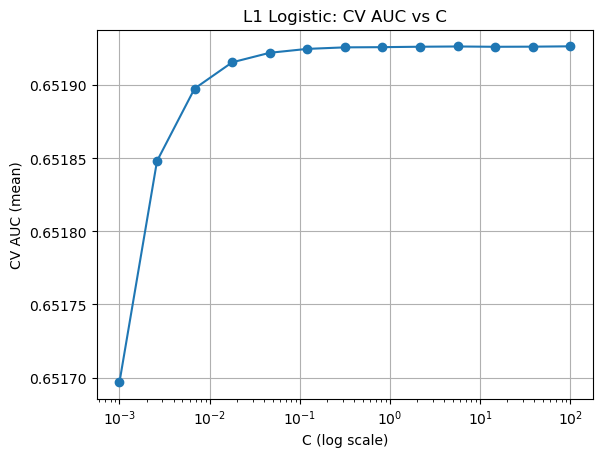

In [64]:
plt.plot(cv_table["C"], cv_table["cv_auc_mean"], marker="o")
plt.xscale("log")
plt.xlabel("C (log scale)"); plt.ylabel("CV AUC (mean)")
plt.title("L1 Logistic: CV AUC vs C"); plt.grid(True); plt.show()

AUC starts to plateau when C reaches 0.3, and there's little gain as C continues to increase past this point. 

That said, for simplicity, **we'll fix C=100** and tune decision threshold next.

## 5. Optimsing Decision Threshold

We have been using THRESH=0.2; there may be room to fine-tune it now that the feature set is finalised and C is optimised.


In [66]:
THRESHOLDS = np.arange(0.1, 0.5, 0.01)
C_TUNED = 100
base_features_finl = reduced_features2
FEATURES = base_features_finl


# --- one-time: make an inner validation split from the dev set (2012-2016) ---
X_dev_train, X_dev_valid, y_dev_train, y_dev_valid = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

Xtr = X_dev_train[FEATURES]
Xva = X_dev_valid[FEATURES]

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        C=C_TUNED,
        max_iter=1000,
        random_state=42
    ))
])

# Fit on training
pipe.fit(Xtr, y_dev_train)

# Get probabilities on validation
proba = pipe.predict_proba(Xva)[:, 1]

# Evaluate across thresholds
results = []
for thresh in THRESHOLDS:
    y_pred = (proba >= thresh).astype(int)
    auc = roc_auc_score(y_dev_valid, proba)
    p1, r1, f1, _ = precision_recall_fscore_support(
        y_dev_valid, y_pred, labels=[1], average=None, zero_division=0
    )
    fpr, tpr, thresholds = roc_curve(y_dev_valid, proba)
    ks = max(tpr - fpr)
    
    results.append({
        "threshold": round(thresh, 3),
        "auc": round(auc, 4),
        "prec1": round(p1[0], 4),
        "recall1": round(r1[0], 4),
        "f1_1": round(f1[0], 4),
        "KS": round(ks, 4)
    })

# View as DataFrame
threshold_df = pd.DataFrame(results)
threshold_df.sort_values("f1_1", ascending=False).head(10)  # Top F1 scores

,threshold,auc,prec1,recall1,f1_1,KS
9,0.19,0.6555,0.2709,0.6737,0.3864,0.2253
10,0.20,0.6555,0.2780,0.6300,0.3858,0.2253
8,0.18,0.6555,0.2637,0.7146,0.3852,0.2253
11,0.21,0.6555,0.2851,0.5860,0.3836,0.2253
7,0.17,0.6555,0.2566,0.7540,0.3829,0.2253
6,0.16,0.6555,0.2502,0.7933,0.3804,0.2253
12,0.22,0.6555,0.2926,0.5424,0.3801,0.2253
5,0.15,0.6555,0.2439,0.8288,0.3768,0.2253
13,0.23,0.6555,0.2994,0.4973,0.3738,0.2253
4,0.14,0.6555,0.2380,0.8621,0.3730,0.2253


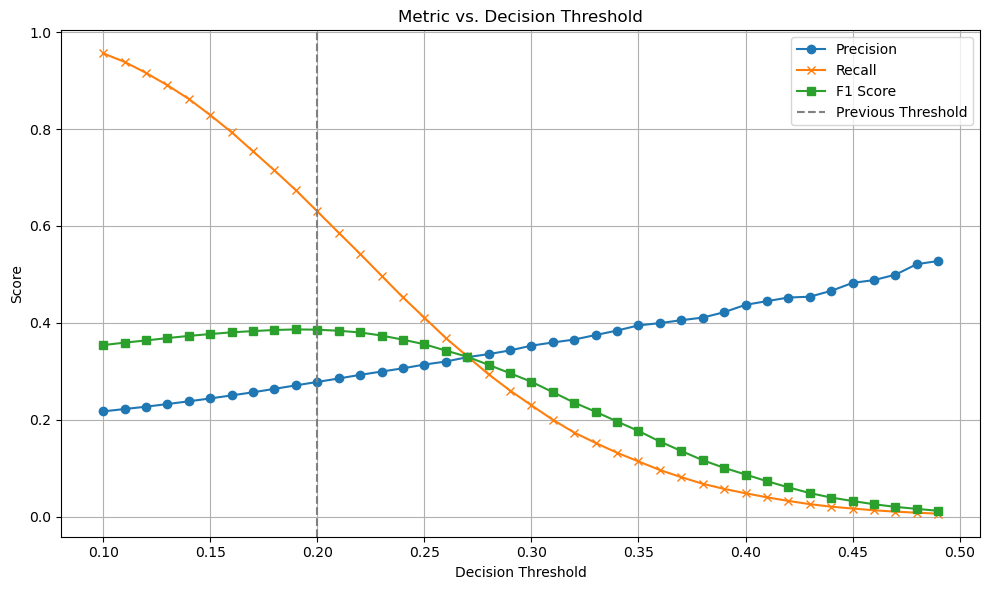

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(threshold_df["threshold"], threshold_df["prec1"], label="Precision", marker='o')
plt.plot(threshold_df["threshold"], threshold_df["recall1"], label="Recall", marker='x')
plt.plot(threshold_df["threshold"], threshold_df["f1_1"], label="F1 Score", marker='s')
plt.axvline(x=0.2, color='grey', linestyle='--', label="Previous Threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Metric vs. Decision Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The decision threshold that yielded the highest f1-score is **0.19**, which isn't far off to the 0.2 threshold we have been using. 

Now, we re-fit the L1 model using the optimised **C=100** and **TRESH=0.19**.

In [101]:
C_TUNED = 100
THRESH_TUNED = 0.19
FEATURES = base_features_finl

final_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        C=C_TUNED,  # from your grid
        max_iter=1000,
        random_state=42
    ))
])

# Fit on full dev dataset
Xtr = df_train[FEATURES]
Xte = df_test[FEATURES]

final_pipe.fit(Xtr, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=100, max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

In [102]:
# Predict on the test set
proba = final_pipe.predict_proba(Xte)[:, 1]
y_pred = (proba >= THRESH_TUNED).astype(int) 

In [106]:
# Evaluate the final model

# AUC
auc_fin = roc_auc_score(y_test, proba)

# Accuracy
acc_fin = accuracy_score(y_test, y_pred)

# Precision, recall and f1_score of class 1
p1_fin, r1_fin, f1_1_fin, _ = precision_recall_fscore_support(
     y_test, y_pred, labels=[1], average=None, zero_division=0
)

# KS statistics
fpr_fin, tpr_fin, thresholds_fin = roc_curve(y_test, proba)
ks_fin = max(tpr_fin - fpr_fin)

# Put together a performance df
finl_perf = pd.Series({
    "model": "L1 Final",
    "predictors": "17 base features v2 minus dti, acc_open_past_24mths, mths_since_recent_inq, F_CAPPED_NUMACCTS_woe",
    "threshold": "0.19 (Opt)",
    "C": "100 (Opt)",
    "auc": round(auc_fin, 4),
    "accuracy": round(acc_fin, 4),
    "precision": round(p1_fin[0], 4),
    "recall": round(r1_fin[0], 4),
    "f1-score": round(f1_1_fin[0],4),
    "KS": round(ks_fin, 4)
})
perf_df = pd.concat([perf_df, finl_perf.to_frame().T], ignore_index=True)

perf_df

,model,predictors,threshold,C,auc,accuracy,precision,recall,f1-score,KS
0,L1,23 base features,0.5,default,0.6889,0.7909,0.5091,0.0798,0.138,0.2744
1,L1,23 base features,0.2,default,0.6889,0.6331,0.3156,0.6414,0.423,0.2744
2,L1,21 base features v2 (excl. f_term_60 and loan_...,0.2,default,0.6582,0.5982,0.2913,0.6393,0.4002,0.2273
3,L1,"19 base features v2 minus dti, acc_open_past_2...",0.2,default,0.6535,0.579,0.2836,0.6602,0.3967,0.2186
4,L1,"17 base features v2 minus dti, acc_open_past_2...",0.2,default,0.6527,0.58,0.2841,0.66,0.3972,0.219
5,Elastic Net,"17 base features v2 minus dti, acc_open_past_2...",0.2,default,0.6527,0.58,0.2841,0.66,0.3972,0.219
6,L1 (Benchmark),"int_rate, f_term_60, loan_amnt",0.2,default,0.6821,0.6255,0.3082,0.6315,0.4142,0.2645
7,L1 Final,"17 base features v2 minus dti, acc_open_past_2...",0.19 (Opt),100 (Opt),0.6527,0.5558,0.2776,0.6977,0.3971,0.219


In [72]:
# Get coefficients and column names
coefs_finl = final_pipe["clf"].coef_[0]
feature_names_finl = Xtr.columns

# Create a DataFrame of coefficients
coef_df_finl = pd.DataFrame({
    'feature': feature_names_finl,
    'coefs': coefs_finl
})

# Filter out zero coefficients
nonzero_coefs_finl = coef_df_finl[coef_df_finl['coefs'] != 0]

# Sort by absolute value
nonzero_coefs_sorted_finl = nonzero_coefs_finl.reindex(
    nonzero_coefs_finl['coefs'].abs().sort_values(ascending=False).index
)

print(f"Number of non-zero features: {len(nonzero_coefs_sorted_finl)}")
nonzero_coefs_sorted_finl

Number of non-zero features: 17


,feature,coefs
1,fico_range_low_woe,-0.195032
12,verification_status_woe,0.182480
9,num_rev_tl_bal_gt_0_woe,-0.170093
3,mths_since_rcnt_il_woe,-0.141757
4,bc_open_to_buy_woe,-0.137573
0,annual_inc_woe,-0.117521
13,addr_state_grouped_woe,0.112187
14,purpose_woe,0.104476
2,inq_last_6mths_woe,-0.097093
6,mo_sin_rcnt_tl_woe,-0.079244


## 6. Backup Features Forward Selection

In [73]:
# Backup Features
backup_vars = list(summary[summary['decision']=='keep - backup']['variable'])

suffix = "_woe"
backup_features = [var + suffix for var in backup_vars]

backup_features

['mths_since_last_major_derog_woe',
 'total_bal_il_woe',
 'open_rv_24m_woe',
 'max_bal_bc_woe',
 'all_util_woe',
 'total_rev_hi_lim_woe',
 'inq_last_12m_woe',
 'bc_util_woe',
 'mo_sin_rcnt_rev_tl_op_woe',
 'num_tl_op_past_12m_woe',
 'tot_hi_cred_lim_woe',
 'f_hi_risk_zip_woe',
 'f_miss_block1_woe',
 'F_CAPPED_AMOUNT_woe',
 'F_CAPPED_INC_woe']

In [74]:
# Setup comprehensive feature set & split
X_train_all = df_train[base_features_v2 + backup_features]

X_dev_train, X_dev_valid, y_dev_train, y_dev_valid = train_test_split(
    X_train_all, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Fixed C & Decision Treshold
THRESH = 0.19
C_FIXED = 100


# Forward selection setup
selected_features = base_features_finl.copy()
remaining_features = backup_features.copy()

best_f1 = fit_eval(selected_features)["f1_1"]

while True:
    improvement = False
    best_candidate = None
    best_score = best_f1

    for feature in remaining_features:
        trial_features = selected_features + [feature]
        score = fit_eval(trial_features)["f1_1"]

        if score > best_score + 0.001:  # small margin to justify inclusion
            best_score = score
            best_candidate = feature
            improvement = True

    if improvement:
        selected_features.append(best_candidate)
        remaining_features.remove(best_candidate)
        best_f1 = best_score
        print(f"Added: {best_candidate}, new f1: {best_score}")
    else:
        print("No more useful features to add.")
        break

Added: num_tl_op_past_12m_woe, new f1: 0.3879
No more useful features to add.


In [75]:
# Base model - 17 features on the 80/20 train-validation set z
fit_eval(base_features_finl)

{'auc': 0.6555,
 'prec1': 0.2709,
 'recall1': 0.6737,
 'f1_1': 0.3864,
 'KS': 0.2253}

Forward selection on the 15 backup variables: only one feature (`num_tl_op_12m`) was selected.The F1-score improved from **0.3864 → 0.3879** (0.15 percentage point). This implies

1. Most of the predictive signal is already captured by the 17 core variables.
2. The “backup” features probably don’t contain much additional signal — or what little signal they have, overlaps with what’s already in the model. 

**Next Step:**
Refit the model on the full train set (2016 and prior) and predict on the full test set (2017-2018)

In [108]:
C_TUNED = 100
THRESH_TUNED = 0.19
FEATURES = base_features_finl + ['num_tl_op_past_12m_woe']


final_pipe_v2 = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        C=0.19,
        max_iter=1000,
        random_state=42
    ))
])


# Fit on full dev dataset
Xtr = df_train[FEATURES]
Xte = df_test[FEATURES]

final_pipe_v2.fit(Xtr, y_train)

# Predict on the test set
proba_add = final_pipe_v2.predict_proba(Xte)[:, 1]
y_pred_add = (proba >= THRESH_TUNED).astype(int) 

# Evaluate the final model

# AUC
auc_add = roc_auc_score(y_test, proba_add)

# Accuracy
acc_add = accuracy_score(y_test, y_pred_add)

# Precision, recall and f1_score of class 1
p1_add, r1_add, f1_1_add, _ = precision_recall_fscore_support(
     y_test, y_pred_add, labels=[1], average=None, zero_division=0
)

# KS statistics
fpr_add, tpr_add, thresholds_fin = roc_curve(y_test, proba_add)
ks_add = max(tpr_add - fpr_add)

# Put together a performance df
add_perf = pd.Series({
    "model": "L1 Final + Backup Var",
    "predictors": "18 L1 Final + num_tl_op_past_12m_woe",
    "threshold": "0.19 (Opt)",
    "C": "100 (Opt)",
    "auc": round(auc_fin, 4),
    "accuracy": round(acc_fin, 4),
    "precision": round(p1_fin[0], 4),
    "recall": round(r1_fin[0], 4),
    "f1-score": round(f1_1_fin[0], 4),
    "KS": round(ks_add, 4)
})
perf_df = pd.concat([perf_df, add_perf.to_frame().T], ignore_index=True)

perf_df

,model,predictors,threshold,C,auc,accuracy,precision,recall,f1-score,KS
0,L1,23 base features,0.5,default,0.6889,0.7909,0.5091,0.0798,0.138,0.2744
1,L1,23 base features,0.2,default,0.6889,0.6331,0.3156,0.6414,0.423,0.2744
2,L1,21 base features v2 (excl. f_term_60 and loan_...,0.2,default,0.6582,0.5982,0.2913,0.6393,0.4002,0.2273
3,L1,"19 base features v2 minus dti, acc_open_past_2...",0.2,default,0.6535,0.579,0.2836,0.6602,0.3967,0.2186
4,L1,"17 base features v2 minus dti, acc_open_past_2...",0.2,default,0.6527,0.58,0.2841,0.66,0.3972,0.219
5,Elastic Net,"17 base features v2 minus dti, acc_open_past_2...",0.2,default,0.6527,0.58,0.2841,0.66,0.3972,0.219
6,L1 (Benchmark),"int_rate, f_term_60, loan_amnt",0.2,default,0.6821,0.6255,0.3082,0.6315,0.4142,0.2645
7,L1 Final,"17 base features v2 minus dti, acc_open_past_2...",0.19 (Opt),100 (Opt),0.6527,0.5558,0.2776,0.6977,0.3971,0.219
8,L1 Final + Backup Var,18 L1 Final + num_tl_op_past_12m_woe,0.19 (Opt),100 (Opt),0.6527,0.5558,0.2776,0.6977,0.3971,0.2138


There's not only no substantial improvement on model performance, but recall decreased by 1 base point by introducing the backup variable `num_tl_op_past_12m`. It might be mildly correlated with existing features, or just not strong enough to shift the decision boundary in a meaningful way.

**Decision:** not to include `num_tl_op_past_12m` in the final model.

## 7. Final Model Summaryaccuracy_score

**1. Objective**

This project aimed to build a binary classification scorecard model to predict loan default risk based on borrower and account features from the Lending Club dataset. The modelling objective was to simulate the development of a traditional credit scorecard, using domain-informed techniques such as WOE binning, L1 regularisation, and out-of-time validation.

⸻⸻

**2. Sample Definition**
- <u>Target Variable</u>: `GB_FLAG` (good-bad flag) derived from `loan_status` where
    - 1 = *Default*, *Charged Off*, or *Does not meet the credit policy. Status:Charged Off*
    - 0 = *Fully Paid*, or *Does not meet the credit policy. Status:Fully Paid*
- <u>Sample size</u>: 1,348,132 records of <font color="blue">approved and complete loans</font> between year 2012 - 2018. Rejected and current loans (in good standing and in arrears) have been excluded from the sample.
- <u>Dev/test split</u>:
    - Development: 2012-2016 sample (1,074,238 records)
    - Out-of-time (OOT) testing: 2017-2018 sample (205,520 records)

⸻⸻

**3. Feature Engineering & Selection**

- The initial feature selection yields a core feature set of **24** predictors, and a backup set of 15 from 103 variables based on IV signals and domain knowledge. All variables were WOE-binned and standardised prior to modelling.
- 3 Variables (`int_rate`, `f_term_60`, `loan_amnt`)from the core feature set were excluded at the modelling stage due to information leakage — they are outputs of Lending Club’s iternal risk-based pricing and would artificially inflate model performance, reducing the core feature set to **21** predictors. 
- The final model includes:
    - **17 predictors** from the core feature set, selected via L1 regularisation. 3 variables were dropped due to unstable or contradictory coefficients: (`dti`, `acc_open_past_24mnths`, `mths_since_recent_inq`)resulting in improved generalisation, and 1 variable due to minial contribution to the model performance (`F_CAPPED_NUMACCTS`), 
    - Forward selection was performed on the 15-variable backup set, and none was found to improve the model performance on the OOT sample significantly.

⸻⸻

**4. Model Performance**

<u>Final Model (L1-regularised Logistic Regression):</u>
- Number of predictors: 17
- C (inverse regularisation strength): 100
- Optimised threshold: 0.19

Performance on OOT test set
- AUC: 0.65
- F1 Score: 0.40
- Precision: 0.28
- Recall: 0.70
- Accuracy: 0.56
- KS: 0.22

<u>Benchmark Model:</u>
- L1-regularised Logistic Regression with 3 risk-based pricing output variables: `int_rate`, `f_term_60`, `loan_amnt`
- AUC: 0.68
- F1 Score: 0.41
- Precision: 0.31
- Recall: 0.63
- Accuracy: 0.63
- KS: 0.26

The final model performs comparably to the benchmark without relying on any pricing-based leakage variables, demonstrating reasonable generalisability and interpretability.

⸻⸻

**5. Top Features**
- `fico_range_low` (-0.19): bureau score, as expected is the top predictor; the higher the score, the lower the likelihood to default.
- `verification_status` (0.18): income verification marker; applicants with verified income or income source is less likely too default.
- `num_rev_tl_bal_gt_0` (-0.17): the number of revolving accounts with non-zero balance. A customer with more open and active accounts on their bureau profile must have been approved for these lending products prior, could signal credit-worthiness. Unexpected but not illogical.
- `bc_open_to_buy` (-0.14): remaining credit cards limit. More limit left to spend signals less need for credit, therefore the lower the likelihood of default.
- `mths_since_rcnt_il` (-0.14): the longer time since the last installment account, the lower the likelihood of delinquency. Lower product frequencies signals lower appetite for credit.


## 8. Export Modelling Output

In [109]:
# Export Final Model Object

joblib.dump(final_pipe, 'final_model_pipeline.pkl')

['final_model_pipeline.pkl']

In [110]:
# Final Feature List

with open("final_features.txt", "w") as f:
    for feat in base_features_finl:
        f.write(feat + "\n")

In [111]:
# Final Coefficient

coefs = final_pipe.named_steps['clf'].coef_[0]
feature_names = base_features_finl
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefs})
coef_df.to_csv("model_coefficients.csv", index=False)

In [113]:
# Final Threshold and C

params = {"C": 100, "threshold": 0.19}
with open("model_params.json", "w") as f:
    json.dump(params, f)

In [115]:
# Performance Metrics
perf_df.to_csv("model_performance.csv", index=False)